# Quickstart

**This is a very quick non-imaging introduction to Nipype workflows. For more comprehensive introduction, check the next section of the tutorial.** 

![Nipype architecture](https://raw.github.com/satra/intro2nipype/master/images/arch.png)

- [Existing documentation](http://nipype.readthedocs.io/en/latest/)

- [Visualizing the evolution of Nipype](https://www.youtube.com/watch?v=cofpD1lhmKU)

- This notebook taken from [reproducible-imaging repository](https://github.com/ReproNim/reproducible-imaging)

#### Import a few things from nipype

In [1]:
import os
from nipype import Workflow, Node, Function

Creating Workflow with one Node that adds two numbers

In [2]:
def sum(a, b):
    return a + b

wf = Workflow('hello')

adder = Node(Function(input_names=['a', 'b'],
                      output_names=['sum'],
                      function=sum), 
             name='a_plus_b')

adder.inputs.a = 1
adder.inputs.b = 3

wf.add_nodes([adder])

wf.base_dir = os.getcwd()

eg = wf.run()

eg.nodes()[0].result.outputs

170903-22:30:01,744 workflow INFO:
	 Workflow hello settings: ['check', 'execution', 'logging']
170903-22:30:01,746 workflow INFO:
	 Running serially.
170903-22:30:01,747 workflow INFO:
	 Executing node a_plus_b in dir: /repos/nipype_tutorial/notebooks/hello/a_plus_b



sum = 4

Creating a second node and connecting to the ``hello`` Workflow 

In [3]:
def concat(a, b):
    return [a, b]


concater = Node(Function(input_names=['a', 'b'],
                         output_names=['some_list'],
                         function=concat), 
                name='concat_a_b')

wf.connect(adder, 'sum', concater, 'a')
concater.inputs.b = 3

eg = wf.run()
print(eg.nodes())

170903-22:30:01,778 workflow INFO:
	 Workflow hello settings: ['check', 'execution', 'logging']
170903-22:30:01,783 workflow INFO:
	 Running serially.
170903-22:30:01,784 workflow INFO:
	 Executing node a_plus_b in dir: /repos/nipype_tutorial/notebooks/hello/a_plus_b
170903-22:30:01,790 workflow INFO:
	 Executing node concat_a_b in dir: /repos/nipype_tutorial/notebooks/hello/concat_a_b
[hello.a_plus_b, hello.concat_a_b]


And we can check results of our Workflow, we should see a list:

In [4]:
eg.nodes()[-1].result.outputs


some_list = [4, 3]

We will try to add additional Node that adds one:

In [5]:
def plus_one(a):
    print("PLUS ONE, a = {}".format(a))
    return a + 1

plusone = Node(Function(input_names=['a'],
                        output_names=['out'],
                        function=plus_one), 
               name='add_1')

wf.connect(concater, 'some_list', plusone, 'a')

eg = wf.run()
print(eg.nodes())

170903-22:30:01,819 workflow INFO:
	 Workflow hello settings: ['check', 'execution', 'logging']
170903-22:30:01,822 workflow INFO:
	 Running serially.
170903-22:30:01,824 workflow INFO:
	 Executing node a_plus_b in dir: /repos/nipype_tutorial/notebooks/hello/a_plus_b
170903-22:30:01,825 workflow INFO:
170903-22:30:01,827 workflow INFO:
	 Executing node concat_a_b in dir: /repos/nipype_tutorial/notebooks/hello/concat_a_b
170903-22:30:01,835 workflow INFO:
	 Executing node add_1 in dir: /repos/nipype_tutorial/notebooks/hello/add_1
PLUS ONE, a = [4, 3]
170903-22:30:01,840 workflow ERROR:
	 ['Node add_1 failed to run on host c9e1069a3506.']
170903-22:30:01,842 workflow INFO:
	 Saving crash info to /repos/nipype_tutorial/notebooks/crash-20170903-223001-neuro-add_1-5ddf08e7-c93d-4853-9527-619a6a570a39.pklz
170903-22:30:01,843 workflow INFO:
	 Traceback (most recent call last):
  File "/opt/conda/envs/neuro3/lib/python3.6/site-packages/nipype/pipeline/plugins/linear.py", line 43, in run
    n

RuntimeError: Workflow did not execute cleanly. Check log for details

This time the workflow didn't execute cleanly and we got an error. We can use ``nipypecli`` to read the crashfile (note, that if you have multiple crashfiles in the directory you'll have to provide a full name):

In [6]:
!LC_ALL= nipypecli crash crash*

Traceback (most recent call last):
  File "/opt/conda/envs/neuro3/bin/nipypecli", line 11, in <module>
    load_entry_point('nipype==1.0.0.dev0', 'console_scripts', 'nipypecli')()
  File "/opt/conda/envs/neuro3/lib/python3.6/site-packages/click/core.py", line 722, in __call__
    return self.main(*args, **kwargs)
  File "/opt/conda/envs/neuro3/lib/python3.6/site-packages/click/core.py", line 676, in main
    _verify_python3_env()
  File "/opt/conda/envs/neuro3/lib/python3.6/site-packages/click/_unicodefun.py", line 118, in _verify_python3_env
    'for mitigation steps.' + extra)
RuntimeError: Click will abort further execution because Python 3 was configured to use ASCII as encoding for the environment.  Consult http://click.pocoo.org/python3/for mitigation steps.

This system supports the C.UTF-8 locale which is recommended.
You might be able to resolve your issue by exporting the
following environment variables:

    export LC_ALL=C.UTF-8
    export LANG=C.UTF-8


It clearly shows the problematic Node and the its input. We tried to add an integer to a list, this operation is not allowed in Python. 

Let's try using MapNode

In [7]:
from nipype import MapNode

plusone = MapNode(Function(input_names=['a'],
                           output_names=['out'],
                           function=plus_one), 
                  iterfield=['a'],
                  name='add_1')

wf = Workflow('hello_mapnode')

adder = Node(Function(input_names=['a', 'b'],
                      output_names=['sum'],
                      function=sum), 
             name='a_plus_b')

adder.inputs.a = 1
adder.inputs.b = 3
wf.connect(adder, 'sum', concater, 'a')
concater.inputs.b = 3

wf.connect(concater, 'some_list', plusone, 'a')

wf.base_dir = os.getcwd()

eg = wf.run()
print(eg.nodes())

170903-22:30:10,606 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170903-22:30:10,610 workflow INFO:
	 Running serially.
170903-22:30:10,611 workflow INFO:
	 Executing node a_plus_b in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/a_plus_b
170903-22:30:10,618 workflow INFO:
	 Executing node concat_a_b in dir: /repos/nipype_tutorial/notebooks/hello/concat_a_b
170903-22:30:10,620 workflow INFO:
170903-22:30:10,622 workflow INFO:
	 Executing node add_1 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/add_1
170903-22:30:10,625 workflow INFO:
	 Executing node _add_10 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/add_1/mapflow/_add_10
PLUS ONE, a = 4
170903-22:30:10,632 workflow INFO:
	 Executing node _add_11 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/add_1/mapflow/_add_11
PLUS ONE, a = 3
[hello_mapnode.a_plus_b, hello.concat_a_b, hello_mapnode.add_1]


Now the workflow finished without problems, let's see the results from ``hello.add_1``:

In [8]:
print(eg.nodes()[2].result.outputs)

Bunch(out=[5, 4])


And now we will run example with ``iterables``:

In [9]:
adder.iterables = ('a', [1, 2])
adder.inputs.b = 2

eg = wf.run()
print(eg.nodes())

170903-22:30:11,71 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170903-22:30:11,83 workflow INFO:
	 Running serially.
170903-22:30:11,84 workflow INFO:
	 Executing node a_plus_b.aI.a1 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/a_plus_b
170903-22:30:11,91 workflow INFO:
	 Executing node concat_a_b.a1 in dir: /repos/nipype_tutorial/notebooks/hello/_a_2/concat_a_b
170903-22:30:11,97 workflow INFO:
	 Executing node add_1.a1 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/add_1
170903-22:30:11,101 workflow INFO:
	 Executing node _add_10 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/add_1/mapflow/_add_10
PLUS ONE, a = 4
170903-22:30:11,108 workflow INFO:
	 Executing node _add_11 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/add_1/mapflow/_add_11
PLUS ONE, a = 3
170903-22:30:11,116 workflow INFO:
	 Executing node a_plus_b.aI.a0 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_1/a_plus_b
17

Now we have 6 nodes, we can check results for `` hello.add_1.a1``

In [10]:
eg.nodes()[5].result.outputs

Bunch(out=[5, 4])

In [11]:
wf.write_graph(graph2use='exec')

170903-22:30:12,24 workflow INFO:
	 Generated workflow graph: /repos/nipype_tutorial/notebooks/hello_mapnode/graph.dot.png (graph2use=exec, simple_form=True).


'/repos/nipype_tutorial/notebooks/hello_mapnode/graph.dot.png'

In [12]:
from IPython.display import Image

We can plot a general structure of the workflow:

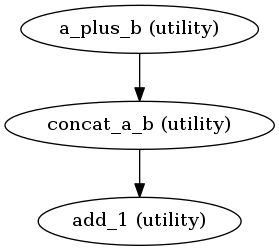

In [13]:
Image("hello_mapnode/graph.dot.png")

And more detailed structure with all nodes:

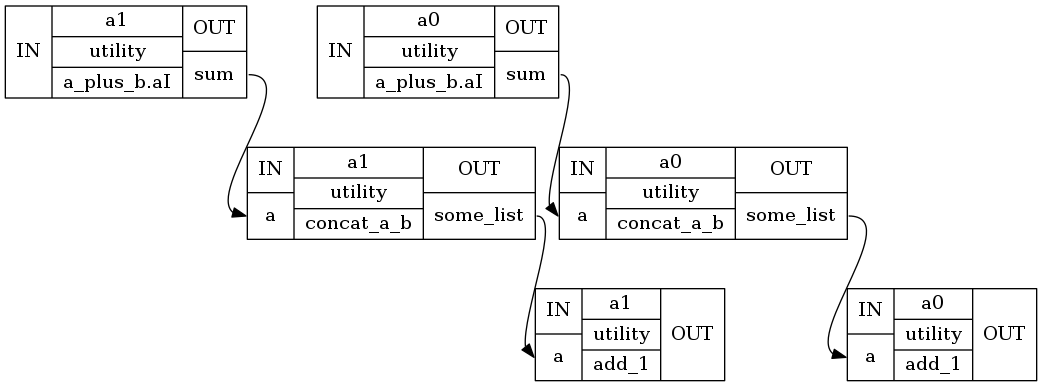

In [14]:
Image("hello_mapnode/graph_detailed.dot.png")

We will introduce another iterables, for the concater Node:

In [15]:
concater.iterables = ('b', [3, 4])
eg = wf.run()
eg.nodes()

170903-22:30:13,992 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170903-22:30:14,4 workflow INFO:
	 Running serially.
170903-22:30:14,5 workflow INFO:
	 Executing node a_plus_b.bI.b1 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/a_plus_b
170903-22:30:14,7 workflow INFO:
170903-22:30:14,9 workflow INFO:
	 Executing node concat_a_b.aI.a0.b1 in dir: /repos/nipype_tutorial/notebooks/hello/_a_2/_b_3/concat_a_b
170903-22:30:14,16 workflow INFO:
	 Executing node add_1.a0.b1 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1
170903-22:30:14,22 workflow INFO:
	 Executing node _add_10 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1/mapflow/_add_10
PLUS ONE, a = 4
170903-22:30:14,31 workflow INFO:
	 Executing node _add_11 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1/mapflow/_add_11
PLUS ONE, a = 3
170903-22:30:14,41 workflow INFO:
	 Executing node concat_a_b.aI.a1.b1 in dir: /

[hello_mapnode.a_plus_b.bI.b0,
 hello.concat_a_b.aI.a0.b0,
 hello_mapnode.add_1.a0.b0,
 hello.concat_a_b.aI.a1.b0,
 hello_mapnode.add_1.a1.b0,
 hello_mapnode.a_plus_b.bI.b1,
 hello.concat_a_b.aI.a0.b1,
 hello_mapnode.add_1.a0.b1,
 hello.concat_a_b.aI.a1.b1,
 hello_mapnode.add_1.a1.b1]

In [16]:
wf.write_graph(graph2use='exec')

170903-22:30:14,414 workflow INFO:
	 Generated workflow graph: /repos/nipype_tutorial/notebooks/hello_mapnode/graph.dot.png (graph2use=exec, simple_form=True).


'/repos/nipype_tutorial/notebooks/hello_mapnode/graph.dot.png'

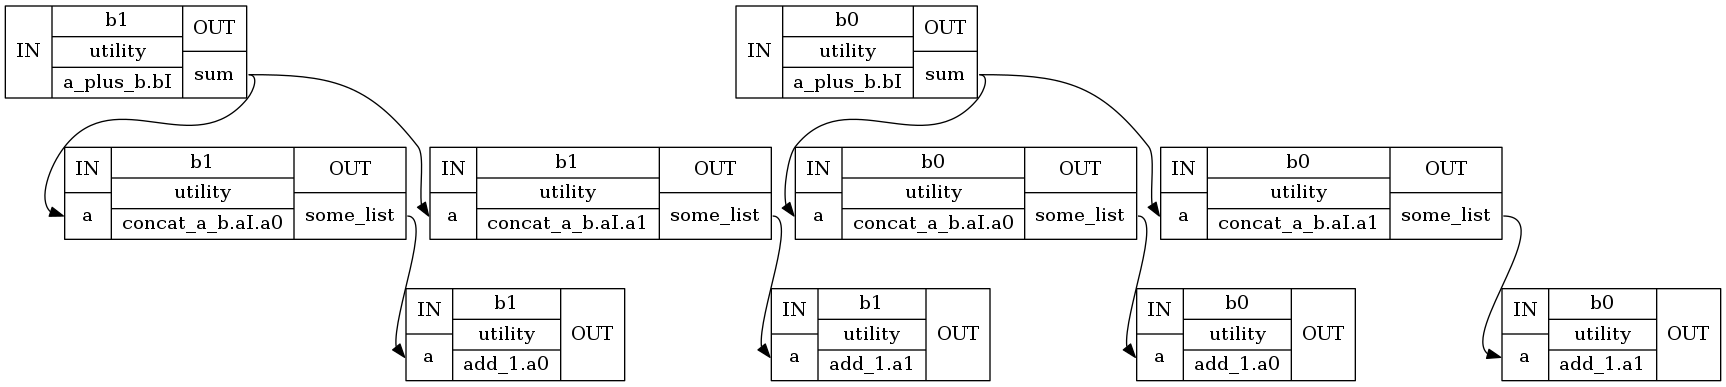

In [17]:
Image("hello_mapnode/graph_detailed.dot.png")

Now we will introduce JoinNode that allows us to merge results together:

In [18]:
def merge_and_scale_data(data2):
    import numpy as np
    return (np.array(data2) * 1000).tolist()


from nipype import JoinNode
joiner = JoinNode(Function(input_names=['data2'],
                          output_names=['data_scaled'],
                          function=merge_and_scale_data),
                 name='join_scale_data',
                 joinsource=adder,
                 joinfield=['data2'])

wf.connect(plusone, 'out', joiner, 'data2')

eg = wf.run()
eg.nodes()

170903-22:30:15,790 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170903-22:30:15,805 workflow INFO:
	 Running serially.
170903-22:30:15,807 workflow INFO:
	 Executing node a_plus_b.bI.b1 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/a_plus_b
170903-22:30:15,808 workflow INFO:
170903-22:30:15,810 workflow INFO:
	 Executing node concat_a_b.aI.a0.b1 in dir: /repos/nipype_tutorial/notebooks/hello/_a_2/_b_3/concat_a_b
170903-22:30:15,812 workflow INFO:
170903-22:30:15,814 workflow INFO:
	 Executing node add_1.a0.b1 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1
170903-22:30:15,818 workflow INFO:
	 Executing node _add_10 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1/mapflow/_add_10
PLUS ONE, a = 4
170903-22:30:15,825 workflow INFO:
	 Executing node _add_11 in dir: /repos/nipype_tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1/mapflow/_add_11
PLUS ONE, a = 3
170903-22:30:15,838 workflow INFO:

[hello_mapnode.join_scale_data.a0,
 hello_mapnode.join_scale_data.a1,
 hello_mapnode.a_plus_b.bI.b0,
 hello.concat_a_b.aI.a0.b0,
 hello_mapnode.add_1.a0.b0,
 hello.concat_a_b.aI.a1.b0,
 hello_mapnode.add_1.a1.b0,
 hello_mapnode.a_plus_b.bI.b1,
 hello.concat_a_b.aI.a0.b1,
 hello_mapnode.add_1.a0.b1,
 hello.concat_a_b.aI.a1.b1,
 hello_mapnode.add_1.a1.b1]

Let's check the output of ``hello.join_scale_data.a0`` node:

In [19]:
eg.nodes()[0].result.outputs


data_scaled = [[4000, 4000], [5000, 4000]]

In [20]:
wf.write_graph(graph2use='exec')

170903-22:30:16,978 workflow INFO:
	 Generated workflow graph: /repos/nipype_tutorial/notebooks/hello_mapnode/graph.dot.png (graph2use=exec, simple_form=True).


'/repos/nipype_tutorial/notebooks/hello_mapnode/graph.dot.png'

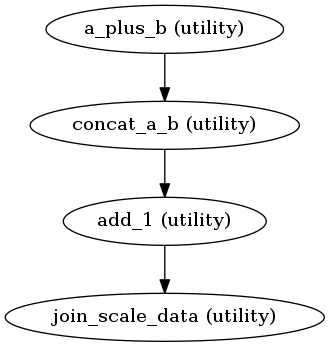

In [21]:
Image("hello_mapnode/graph.dot.png")

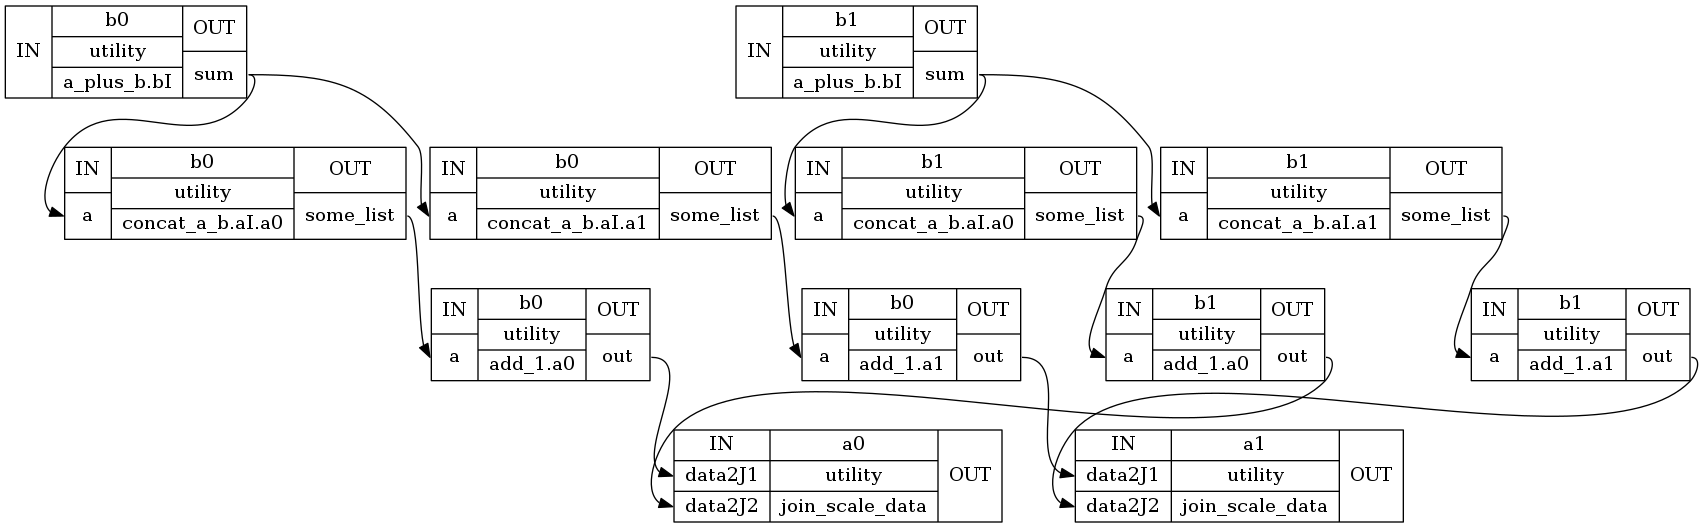

In [22]:
Image("hello_mapnode/graph_detailed.dot.png")

In [23]:
%time eg = wf.run(plugin='MultiProc', plugin_args={'n_procs': 2})

170903-22:30:17,298 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170903-22:30:17,315 workflow INFO:
	 Running in parallel.
170903-22:30:17,318 workflow INFO:
	 Executing: a_plus_b.bI.b1 ID: 0
170903-22:30:17,322 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b1 jobid: 0
170903-22:30:17,324 workflow INFO:
	 Executing: a_plus_b.bI.b0 ID: 5
170903-22:30:17,325 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b0 jobid: 5
...
170903-22:30:17,437 workflow INFO:
	 [Job finished] jobname: join_scale_data.a1 jobid: 10
CPU times: user 136 ms, sys: 36 ms, total: 172 ms
Wall time: 161 ms


In [24]:
wf.base_dir = os.path.join(os.getcwd(), 'alt')

In [25]:
%time eg = wf.run(plugin='MultiProc', plugin_args={'n_procs': 2})

170903-22:30:18,129 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170903-22:30:18,143 workflow INFO:
	 Running in parallel.
170903-22:30:18,147 workflow INFO:
	 Executing: a_plus_b.bI.b1 ID: 0
170903-22:30:18,149 workflow INFO:
	 Executing: a_plus_b.bI.b0 ID: 5
170903-22:30:18,150 workflow INFO:
	 Executing node a_plus_b.bI.b1 in dir: /repos/nipype_tutorial/notebooks/alt/hello_mapnode/_a_2/a_plus_b
170903-22:30:18,152 workflow INFO:
	 Executing node a_plus_b.bI.b0 in dir: /repos/nipype_tutorial/notebooks/alt/hello_mapnode/_a_1/a_plus_b
170903-22:30:18,161 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b1 jobid: 0
...
170903-22:30:18,360 workflow INFO:
170903-22:30:18,369 workflow INFO:
	 [Job finished] jobname: add_1.a1.b0 jobid: 9
170903-22:30:18,374 workflow INFO:
	 Executing: join_scale_data.a1 ID: 10
170903-22:30:18,377 workflow INFO:
	 Executing node join_scale_data.a1 in dir: /repos/nipype_tutorial/notebooks/alt/hello_mapnode/_b_4/join_

In [26]:
%time eg = wf.run(plugin='MultiProc', plugin_args={'n_procs': 2})

170903-22:30:19,58 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170903-22:30:19,73 workflow INFO:
	 Running in parallel.
170903-22:30:19,77 workflow INFO:
	 Executing: a_plus_b.bI.b1 ID: 0
170903-22:30:19,80 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b1 jobid: 0
170903-22:30:19,82 workflow INFO:
	 Executing: a_plus_b.bI.b0 ID: 5
170903-22:30:19,84 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b0 jobid: 5
170903-22:30:19,89 workflow INFO:
	 Executing: concat_a_b.aI.a0.b1 ID: 1
170903-22:30:19,92 workflow INFO:
	 [Job finished] jobname: concat_a_b.aI.a0.b1 jobid: 1
170903-22:30:19,94 workflow INFO:
	 Executing: concat_a_b.aI.a1.b1 ID: 3
170903-22:30:19,96 workflow INFO:
	 [Job finished] jobname: concat_a_b.aI.a1.b1 jobid: 3
170903-22:30:19,103 workflow INFO:
	 Executing: add_1.a0.b1 ID: 2
170903-22:30:19,107 workflow INFO:
	 Adding 2 jobs for mapnode add_1.a0.b1
170903-22:30:19,111 workflow INFO:
	 Executing: add_1.a1.b1 ID: 4
...
1

### Exercise 1

Create a workflow to calculate a sum of factorials of numbers from a range between $n_{min}$ and $n_{max}$, i.e.:

$$\sum _{k=n_{min}}^{n_{max}} k! = 0! + 1! +2! + 3! + \cdots$$ 

if $n_{min}=0$ and $n_{max}=3$
$$\sum _{k=0}^{3} k! = 0! + 1! +2! + 3!  =  1 + 1 + 2 + 6 = 10$$


In [ ]:
from nipype import Workflow, Node, MapNode, Function
import os

def range_fun(n_min, n_max):
    return list(range(n_min, n_max+1))

def factorial(n):
    # print("FACTORIAL, {}".format(n))
    import math
    return math.factorial(n)

def summing(terms):
    return sum(terms)

wf_ex1 = Workflow('ex1')
wf_ex1.base_dir = os.getcwd()

range_nd = Node(Function(input_names=['n_min', 'n_max'],
                         output_names=['range_list'],
                         function=range_fun), 
                name='range_list')

factorial_nd = MapNode(Function(input_names=['n'],
                                output_names=['fact_out'],
                                function=factorial), 
                       iterfield=['n'],
                       name='factorial')

summing_nd = Node(Function(input_names=['terms'],
                           output_names=['sum_out'],
                           function=summing), 
                  name='summing')


range_nd.inputs.n_min = 0
range_nd.inputs.n_max = 3

wf_ex1.add_nodes([range_nd])
wf_ex1.connect(range_nd, 'range_list', factorial_nd, 'n')
wf_ex1.connect(factorial_nd, 'fact_out', summing_nd, "terms")


eg = wf_ex1.run()

let's print all nodes:

In [ ]:
eg.nodes()

the final result should be 10:

In [ ]:
eg.nodes()[2].result.outputs

we can also check the results of two other nodes:

In [ ]:
print(eg.nodes()[0].result.outputs)
print(eg.nodes()[1].result.outputs)

In [ ]:
#write your code here

# 1. write 3 functions: one that return a list of number from specific range, 
#    second that returns n! (you can use math.factorial) and third that sums the elements from a list

# 2. create a workflow and define the working directory

# 3. define 3 nodes using Node and MapNode and connect them within the workflow

# 4. run the workflow and check the results


### Exercise 2

Create a workflow to calculate the following sum for chosen $n$ and five different values of $x$:  $0$, $\frac{1}{2} \pi$, $\pi$, $\frac{3}{2} \pi$, and $ 2 \pi$.

$\sum _{{k=0}}^{{n}}{\frac  {(-1)^{k}}{(2k+1)!}}x^{{2k+1}}\quad =x-{\frac  {x^{3}}{3!}}+{\frac  {x^{5}}{5!}}-\cdots $


In [ ]:
# we can reuse function from previous exercise, but they need some edits
from nipype import Workflow, Node, MapNode, JoinNode, Function
import os
import math

def range_fun(n_max):
    return list(range(n_max+1))

def term(k, x):
    import math
    fract = math.factorial(2 * k + 1)
    polyn = x ** (2 * k + 1) 
    return (-1)**k * polyn / fract

def summing(terms):
    return sum(terms)

wf_ex2 = Workflow('ex2')
wf_ex2.base_dir = os.getcwd()

range_nd = Node(Function(input_names=['n_max'],
                         output_names=['range_list'],
                         function=range_fun), 
                name='range_list')

term_nd = MapNode(Function(input_names=['k', 'x'],
                           output_names=['term_out'],
                           function=term), 
                  iterfield=['k'],
                  name='term')

summing_nd = Node(Function(input_names=['terms'],
                           output_names=['sum_out'],
                           function=summing), 
                name='summing')


range_nd.inputs.n_max = 15

x_list = [0, 0.5 * math.pi, math.pi, 1.5 * math.pi, 2 * math.pi]

term_nd.iterables = ('x', x_list)

wf_ex2.add_nodes([range_nd])
wf_ex2.connect(range_nd, 'range_list', term_nd, 'k')
wf_ex2.connect(term_nd, 'term_out', summing_nd, "terms")


eg = wf_ex2.run()

let's check all nodes

In [ ]:
eg.nodes()

let's print all results of ``ex2.summing``

In [ ]:
print(eg.nodes()[2].result.outputs)
print(eg.nodes()[4].result.outputs)
print(eg.nodes()[6].result.outputs)
print(eg.nodes()[8].result.outputs)
print(eg.nodes()[10].result.outputs)

Great, we just implemented pretty good Sine function! Those number should be approximately 0, 1, 0, -1 and 0. If they are not, try to increase $n_max$.

In [ ]:
# write your solution here

# 1. write 3 functions: one that return a list of number from a range between 0 and some n, 
#    second that returns a term for a specific k, and third that sums the elements from a list

# 2. create a workflow and define the working directory

# 3. define 3 nodes using Node and MapNode and connect them within the workflow

# 4. use iterables for 4 values of x

# 5. run the workflow and check the final results for every value of x


### Exercise 2a

Use JoinNode to combine results from Exercise 2 in one container, e.g. a dictionary, that takes value $x$ as a key and the result from ``summing`` Node as a value.

In [ ]:
def merge_results(results, x):
    return dict(zip(x, results))

join_nd = JoinNode(Function(input_names=['results', 'x'],
                            output_names=['results_cont'],
                            function=merge_results),
                   name='merge',
                   joinsource=term_nd, # this is the node that used iterables for x
                   joinfield=['results'])

# taking the list of arguments from the previous part 
join_nd.inputs.x = x_list

# connecting a new node to the summing_nd
wf_ex2.connect(summing_nd, "sum_out", join_nd, "results")

eg = wf_ex2.run()

let's print all nodes

In [ ]:
eg.nodes()

and results from ``merge`` Node:

In [ ]:
eg.nodes()[1].result.outputs

In [ ]:
# write your code here

# 1. create an additional function that takes 2 list and combines them into one container, e.g. dictionary

# 2. use JoinNode to define a new node that merge results from Exercise 2 and connect it to the workflow

# 3. run the workflow and check the results of the merging node